___
<img style="float: right; margin: 0px 0px 15px 15px;" src="https://www.carrerasenlinea.mx/logos/original/logo-instituto-tecnologico-y-de-estudios-superiores-de-occidente.png" width="150px" height="100px" />

# Microestructuras y Sistema de Trading
## Laboratorio 1

### EQUIPO:
#### - Tere Castillo
#### - Ana Laura Correa
#### - Gaspar Benitez
#### - Marysol Cantarero

#### Situación: 
Acabas de entrar a trabajar a una operadora de fondos de inversión como analista financiero dentro de la mesa de análisis del mercado de renta variable. En la junta trimestral se plantea la posibilidad de crear un fondo propio con exposición al mercado de valores de USA tratando de replicar a los ETFs conocidos como ishares que la empresa BlackRock ofrece. 

La idea es replicar un ETF con posiciones en directo. Te han asignado la tarea de hacer un ejercicio simple de replicar la construcción de un portafolio de inversión y un criterio de rebalanceo lo más parecido a un ETF de ishares que tu selecciones. Esto con la finalidad de comparar los resultados de haber rebalanceado periódicamente el portafolio, ó, no haberlo hecho y continuar todo un año con las mismas posiciones.


#### Resolucion del problema

Los ETF(Exchange Trade Funds) son fondos o instrumentos de inversión cuyos títulos cotizan en la bolsa, al igual que una acción bursátil,pudiendose comprar y vender en cualquier momento, sin necesidad de esperar al cierre del mercado. Su objetivo es replicar el comportamiento de los activos que componen un índice bursátil, ya sea de renta fija, variable, divisas o materias primas u otros activos financieros.

Para este problema se analizara el ETF "iShares U.S. Financials ETF (IYF)" para el mercado de renta variable de USA con posiciones en directo tomando información del 01/Marzo/2018 al 01/Marzo/2019. Sin embargo, el código a realizar debe ser repetible para cualquier ETF.

Las 3 medidas de atribución al desempeño que se eligieron para la comparación de los resultados son: Rendimiento, volatilidad y medidas de desempeño.

#### Características mínimas de solución: 
Debido a tu formación, te piden que este proceso que construyas sea repetible para cualquier ETF y también incluir 3 medidas de atribución al desempeño, tanto para el caso que el ETF nunca hubiese sido rebalanceado como para los casos donde sí. 

En la mesa de análisis están interesados en conocer el proceso que sigues para adquirir, limpiar, dar formato y utilizar los datos, y a pesar que el equipo senior de análisis está compuesto por personal altamente calificado en temas de economía y finanzas, ellos no saben programar por lo que te piden que incluyas el código utilizado, y que sea de manera ordenada y explicando el sentido de las funciones y paqueterías que requeriste. 

Comparar con 1 año de información: 01/Marzo/2017 al 01/Marzo/2018 

Utilizar un ETF de Ishares para el mercado de renta varialbe de USA 

Entregar un Jupyter Notebook con explicación y comentarios en el código 

Crear y actualizar continuamente un repositorio en GitHub para el proyecto.

#### Resolucion del problema

Los ETF(Exchange Trade Funds) son fondos o instrumentos de inversión cuyos títulos cotizan en la bolsa, al igual que una acción bursátil,pudiendose comprar y vender en cualquier momento, sin necesidad de esperar al cierre del mercado. Su objetivo es replicar el comportamiento de los activos que componen un índice bursátil, ya sea de renta fija, variable, divisas o materias primas u otros activos financieros.

Para este problema se analizara el ETF "iShares U.S. Financials ETF (IYF)" para el mercado de renta variable de USA con posiciones en directo tomando información del 01/Marzo/2017 al 01/Marzo/2018. Sin embargo, el código a realizar debe ser repetible para cualquier ETF.

Las 3 medidas de atribución al desempeño que se eligieron para la comparación de los resultados son: Rendimiento, volatilidad y medidas de desempeño.

### Descarga de librerías

In [1]:
# Descarga de librerías
import quandl
import datetime
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

Declaración de variables: Clave API para poder descargar datos, número de archivos, fechas de rebalanceos y tasa libre de riesgo mensual anualizada.

In [2]:
quandl.ApiConfig.api_key = "My9ygJsz7yTDx_9jcneH"  # API key Quandl
narch = 13
fechas = list(['2017-02-28', '2017-03-31', '2017-04-28', '2017-05-31', '2017-06-30',
                 '2017-07-31', '2017-08-31', '2017-09-29', '2017-10-31', '2017-11-30',
                 '2017-12-29', '2018-01-31', '2018-02-28'])
tl = [0.4, 0.74, 0.68, 0.86 , 0.84, 1, 0.95, 0.96, 0.99 , 1.14 ,0.28 , 1.43, 1.5]

### Declaración de funciones

##### Función para descarga de datos del etf, sus tickers y el número de acciones en circulación mensuales durante un año.

In [3]:
# Función para descarga de archivos csv de holdings etf,sus tickers y shares outstanding.
def holdings_csv(narch,name):
    holdings = []
    tickers = []
    shares = []
    for i in range(narch):
        r = name+str(i)+".csv"
        info = pd.read_csv(r,header=10, index_col= 0)
        shar = pd.read_csv(r,nrows=7).loc['Shares Outstanding'][0]
        info = info.dropna() # quitando los datos vacios.
        info = info.drop(columns = ['Name', 'Asset Class', "Market Value", 'Notional Value', 'Sector', 'SEDOL', 'ISIN', 'Exchange'])
        holdings.append(info)
        tickers.append(list(holdings[i].index))
        shares.append(shar)
    return holdings, tickers, shares
holdings, tickers, shares = holdings_csv(narch,"IYF_holdings")

##### Función para descarga de datos de precios históricos.

In [4]:
# Función para descarga de datos históricos y agrupacion de tickers por fecha (QUANDL)
def download_quandl(fechas, tickers):
    date = {'gte': fechas[0], 'lte': fechas[-1] }
    column = {'columns': ['ticker', 'date', 'Adj_close']}
    data = quandl.get_table('WIKI/PRICES', qopts=column, ticker=tickers, date=date, paginate=True)
    data = data.set_index('date')
    data = data.pivot(columns='ticker') # agrupacion de tickers por fecha 
    data.columns = data.columns.droplevel(0)
    return data

##### Función para convertir cualquier lista de tipo caracteres a números flotantes.

In [5]:
#Función para convertir de str a float.
def str_to_float(var):
    st=var
    if type(var[0]) != np.float64:
        st=[]
        for i in var:
            st.append(float(i.replace(',','')))
    return (st)

##### Función para calcular el rendimiento de cualquier serie de datos guardados en una lista

In [6]:
# Función para calcular el rendimiento de las series
def Rend(navN):
    h =[]
    for i in range(len(navN)-1):
        y= np.log(navN[i+1]/navN[i])
        h.append(y)
    return h

#### Función para calcular las medidas de desempeño (Rendimiento, Variación y Sharpe)

In [7]:
#Función para calcular las medidas de desepeño ( Rendimiento, Variación y sharpe)
def medidas_desempeño(Rend,tl):
    media = np.mean(Rend)
    std = np.std(Rend)
    sharpe = (media -tl/12/100)/std
    return media, std, sharpe

### Limpieza de datos

In [8]:
# Juntando tickers para hacer un mismo indice
venta=[] 
igual=[] 
compra=[] 
for i in range(narch-1):
    venta.append(list(set(tickers[i])-set(tickers[i+1]))) # ya no estan, se vendieron.
    igual.append(list(set(tickers[i+1])-set((set(tickers[i+1])-set(tickers[i]))))) # las que permanecieron.
    compra.append(list(set(tickers[i+1])-set(tickers[i])))  # aparecieron, se compraron
venta = list(np.concatenate(venta))
igual = list(np.concatenate(igual))
compra = list(np.concatenate(compra))
indice = list(set(venta+igual+compra))

In [9]:
# Acomodo de información de acuerdo a índice(tickers) en común (Weight(%), Price y Shares)
Weights , Prices, Shares = pd.DataFrame(index=indice) , pd.DataFrame(index=indice), pd.DataFrame(index=indice)
for i in range(narch):
    l,l1,l2= [],[],[]
    for j in range(len(tickers[i])):
        l.append(holdings[i]['Weight (%)'][tickers[i][j]])
        l1.append(holdings[i]['Price'][tickers[i][j]])
        l2.append(holdings[i]['Shares'][tickers[i][j]])
    l , l1, l2 = pd.DataFrame(l, index=tickers[i]),pd.DataFrame(str_to_float(l1), index=tickers[i]),pd.DataFrame(str_to_float(l2), index=tickers[i])
    Weights['Holdings'+str(i)+''] ,Prices['Holdings'+str(i)+''],Shares['Holdings'+str(i)+''] = l ,l1 , l2

# ESCENARIOS

En el primer escenario se replica el etf original para así poder realizar una comparación al final. En los demás escenarios se realizan distintos rebalanceos de la siguiente manera:

Segundo escenario = [0], tercer escenario = [0,1] , cuarto escenario = [0,2] , ... , ultimo escenario = [0,12]

Explicación: En el segundo escenario no hay rebalanceos, es decir, se mantienen las posiciones iniciales durante todo el año. Del tercer al ultimo escenario únicamente hay un rebalanceo mensual, el cual se va recorriendo mensualmente por escenario.

En total habrá 14 escenarios.

### VALOR NAV (Net Asset Value) o VL(Valor liquidativo)

###### El valor liquidativo es el precio al que el inversor paga las participaciones que adquiere del fondo de inversión que escoja. Además, el valor liquidativo sirve de referencia para conocer la rentabilidad de la inversión y por tanto el beneficio que podrá recibir si el inversor decide vender sus participaciones y dar por finalizada su inversión.

NOTA DE ISHARES:
La rentabilidad pasada no es indicativa de la rentabilidad futura y no debe ser el único factor que se considere a la hora de seleccionar un producto. Los datos de rentabilidad se basan en el valor liquidativo (Net Asset Value, NAV) del ETF que puede no ser el mismo que el precio de mercado del ETF. " Los accionistas individuales pueden obtener rendimientos distintos de la rentabilidad del NAV."

###### El valor liquidativo de un fondo de inversión se calcula dividiendo el patrimonio del fondo entre el número de participaciones existentes.

VL = P / N = Patrimonio neto del fondo(Valor de la Cartera del fondo) / Número de participaciones del fondo.

* El valor de la cartera del fondo es *precios x shares*

In [10]:
precios_qdl = download_quandl(fechas, indice).T
dif =list(set(indice)-set(precios_qdl.index))
P=Prices.loc[dif]
P.columns = pd.to_datetime(fechas)
precios_f= precios_qdl.append(P)
precios_f= precios_f.fillna(0).T
precios_f['USD'] = 1
#precios_f= precios_f.T

In [11]:
Agrup = pd.DataFrame(list(precios_f.groupby(pd.Grouper(freq='M'))))

KIM     189857.0
BOKF      9496.0
MMC     229266.0
ARE      39724.0
AON     116989.0
GNW     197316.0
CFFN     57241.0
NLY     453141.0
HCP     208621.0
MKTX     16864.0
JLL      20297.0
UNM     103668.0
CNO      67031.0
REG      46771.0
DCT      40835.0
FRC      68586.0
PRU     191204.0
CLI      40246.0
BXP      68565.0
TRMK     30662.0
ACGL     54811.0
UDR     119415.0
IBKC     19869.0
SNH      93869.0
FCEA     97234.0
PLD     235892.0
DFS     175378.0
WBS      41105.0
AFSI     48500.0
LPLA     35544.0
          ...   
BHF          NaN
LPT      65977.0
BRO      51439.0
MFA     167176.0
WLTW     57327.0
EQR     162598.0
UMBF     19504.0
BLK      54129.0
DRE     158494.0
RNR      13279.0
KMPR     21778.0
AFL     181469.0
FULT     77902.0
XL      120202.0
MBFI     31964.0
PK       51084.0
PNC     216637.0
CFR      25041.0
L       123316.0
EQY      41804.0
AJG      79510.0
CCP      37878.0
FR       52794.0
MSCI     42125.0
BXMT     42306.0
BK      470158.0
AMP      70280.0
SHO      97630

In [75]:
Agrup[1][1]*Shares['Holdings1']

,ACC,ACGL,AFG,AFL,AFSI,AGNC,AGO,AHL,AIG,AIV,...,WRE,WRI,WTFC,WTM,WU,WY,XHR,XL,Y,ZION
2017-03-01,2.580225e+06,4575606.81,2.631393e+06,1.126601e+07,949725.747194,2.325209e+06,2.084960e+06,1.319632e+06,2.303048e+07,2.758103e+06,...,938881.719613,1.545160e+06,1.535531e+06,1.357640e+07,3.633804e+06,9.740019e+06,0.00,4.177424e+06,3652558.80,3.637201e+06
2017-03-02,2.554679e+06,4521596.20,2.596216e+06,1.114405e+07,940708.066383,2.326408e+06,2.060431e+06,1.294409e+06,2.277035e+07,2.729335e+06,...,924354.120189,1.533250e+06,1.500503e+06,1.344351e+07,3.637454e+06,9.774324e+06,0.00,4.125612e+06,3616872.40,3.514476e+06
2017-03-03,2.518913e+06,4524464.02,2.615453e+06,1.115640e+07,943987.223042,2.345595e+06,2.041909e+06,1.292116e+06,2.288438e+07,2.720345e+06,...,924069.265298,1.531927e+06,1.503743e+06,1.331692e+07,3.642929e+06,9.760030e+06,0.00,4.100215e+06,3597133.36,3.545743e+06
2017-03-06,2.487746e+06,4496741.76,2.605285e+06,1.114405e+07,916114.391445,2.340799e+06,2.042510e+06,1.264599e+06,2.272759e+07,2.711955e+06,...,912959.924563,1.509651e+06,1.493012e+06,1.329799e+07,3.631979e+06,9.639960e+06,0.00,4.053483e+06,3593843.52,3.543398e+06
2017-03-07,2.468841e+06,4491962.06,2.602262e+06,1.110700e+07,907096.710635,2.337201e+06,2.042007e+06,1.261160e+06,2.261000e+07,2.722743e+06,...,906977.971859,1.485561e+06,1.483496e+06,1.322302e+07,3.631979e+06,9.568489e+06,0.00,4.076849e+06,3570647.36,3.539490e+06
2017-03-08,2.416215e+06,4490050.18,2.616553e+06,1.109774e+07,894799.873165,2.291632e+06,2.018900e+06,1.257720e+06,2.260644e+07,2.678392e+06,...,889316.968638,1.437381e+06,1.460212e+06,1.323864e+07,3.619203e+06,9.605654e+06,0.00,4.096151e+06,3572152.88,3.537926e+06
2017-03-09,2.372275e+06,4502477.40,2.630019e+06,1.112862e+07,879223.879038,2.291632e+06,1.999811e+06,1.257720e+06,2.252448e+07,2.622655e+06,...,865104.302932,1.407491e+06,1.463451e+06,1.320409e+07,3.590001e+06,9.497018e+06,0.00,4.098183e+06,3573658.40,3.539490e+06
2017-03-10,2.336509e+06,4545016.73,2.641012e+06,1.111781e+07,878813.984456,2.319213e+06,2.012369e+06,1.253134e+06,2.247815e+07,2.602877e+06,...,869946.836073,1.399461e+06,1.455150e+06,1.321800e+07,3.590001e+06,9.514171e+06,0.00,4.109358e+06,3582412.72,3.510567e+06
2017-03-13,2.352348e+06,4554576.13,2.638538e+06,1.112244e+07,885782.192355,2.307221e+06,2.035477e+06,1.255427e+06,2.262782e+07,2.583699e+06,...,867383.142057,1.415967e+06,1.462237e+06,1.318359e+07,3.573575e+06,9.531324e+06,0.00,4.070753e+06,3583137.60,3.519947e+06
2017-03-14,2.348261e+06,4544538.76,2.649256e+06,1.109002e+07,890700.927342,2.292831e+06,2.028444e+06,1.257720e+06,2.252037e+07,2.583699e+06,...,874575.373749,1.433366e+06,1.463046e+06,1.315707e+07,3.699508e+06,9.522748e+06,0.00,4.100377e+06,3579178.64,3.477736e+06


### Escenario A -  Original

In [78]:
# SERIE ORIGINAL
def nav(narch):
    NAVs_diario= []
    nav_mes = []
    Rends_diario=[]
    Rends_mensual=[]
    Dsv_mensual=[]
    Sharpe_mensual=[]
    for i in range(len(Agrup)):
        dif = list(set(indice)-set(tickers[i]))
        g = Agrup[1][i]*Shares['Holdings'+str(i)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [79]:
NAVs_diario,nav_mes,Rends_diario,Rends_mensual,Dsv_mensual,Sharpe_mensual = nav(narch)

### Graficas

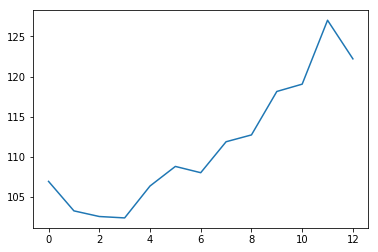

In [15]:
plt.plot(nav_mes)

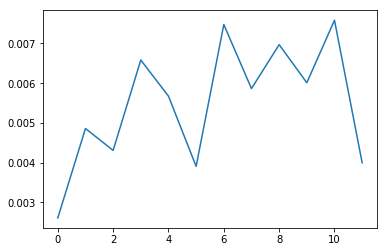

In [16]:
plt.plot(Rends_mensual)

### Escenario B - Sin rebalnceos
Mismas posiciones de Periodo 0.  - > [0]

In [17]:
# SIN REBALANCEOS
def nav1(narch):
    NAVs_diario= []
    nav_mes = []
    Rends_diario=[]
    Rends_mensual=[]
    Dsv_mensual=[]
    Sharpe_mensual=[]
    for i in range(len(Agrup)):
        dif = list(set(indice)-set(tickers[0]))
        g = Agrup[1][i]*Shares['Holdings'+str(0)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [18]:
NAVs_diario1,nav_mes1,Rends_diario1,Rends_mensual1,Dsv_mensual1,Sharpe_mensual1 = nav1(narch)

### Grafica de Rendimiento Original vs. Rendimiento Escenario 1

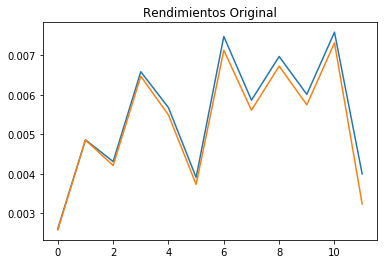

In [19]:
plt.plot(Rends_mensual)
plt.plot(Rends_mensual1)
plt.title('Rendimientos Original')
plt.show()

### Escenario C -  Rebalanceo P1
Mismas posiciones de Periodo 0, rebalanceo Periodo 1 - > [0,1]

In [20]:
# REBALANCEOS
def nav2(narch,preb):
    NAVs_diario= []
    nav_mes = []
    Rends_diario=[]
    Rends_mensual=[]
    Dsv_mensual=[]
    Sharpe_mensual=[]
    for i in range(preb):
        dif = list(set(indice)-set(tickers[0]))
        g = Agrup[1][i]*Shares['Holdings'+str(0)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    for i in range(narch-preb):
        i+=1
        dif = list(set(indice)-set(tickers[preb]))
        g = Agrup[1][i]*Shares['Holdings'+str(preb)+'']
        g= (g.T.drop(dif)).T
        h= [sum(g.loc[j])/str_to_float(shares)[i] for j in list(g.index)] 
        NAVs_diario.append(h)
        nav_mes.append(h[-1])
        Rends_diario.append(Rend(h))
        Rends_mensual.append(np.mean(Rend(h)))
        Dsv_mensual.append(np.std(Rend(h)))
        Sharpe_mensual.append((np.mean(Rend(h))-tl[i]/12/100)/np.std(Rend(h)))
    return NAVs_diario,nav_mes,Rends_diario,Rends_mensual[1:],Dsv_mensual[1:],Sharpe_mensual[1:]

In [21]:
NAVs_diario2,nav_mes2,Rends_diario2,Rends_mensual2,Dsv_mensual2,Sharpe_mensual2 = nav2(narch,1)

### Escenario D-  Rebalanceo P2
Mismas posiciones de Periodo 0, rebalanceo Periodo 2 - > [0,2]

In [22]:
NAVs_diario3,nav_mes3,Rends_diario3,Rends_mensual3,Dsv_mensual3,Sharpe_mensual3 = nav2(narch,2)

### Escenario E -  Rebalanceo P3
Mismas posiciones de Periodo 0, rebalanceo Periodo 3 - > [0,3]

In [23]:
NAVs_diario4,nav_mes4,Rends_diario4,Rends_mensual4,Dsv_mensual4,Sharpe_mensual4 = nav2(narch,3)

### Escenario F -  Rebalanceo P4
Mismas posiciones de Periodo 0, rebalanceo Periodo 4 - > [0,4]

In [24]:
NAVs_diario5,nav_mes5,Rends_diario5,Rends_mensual5,Dsv_mensual5,Sharpe_mensual5 = nav2(narch,4)

### Escenario G -  Rebalanceo P5
Mismas posiciones de Periodo 0, rebalanceo Periodo 5 - > [0,5]

In [25]:
NAVs_diario6,nav_mes6,Rends_diario6,Rends_mensual6,Dsv_mensual6,Sharpe_mensual6 = nav2(narch,5)

### Escenario H -  Rebalanceo P6
Mismas posiciones de Periodo 0, rebalanceo Periodo 6 - > [0,6]

In [26]:
NAVs_diario7,nav_mes7,Rends_diario7,Rends_mensual7,Dsv_mensual7,Sharpe_mensual7 = nav2(narch,6)

### Escenaro I -  Rebalanceo P7
Mismas posiciones de Periodo 0, rebalanceo Periodo 7 - > [0,7]

In [27]:
NAVs_diario8,nav_mes8,Rends_diario8,Rends_mensual8,Dsv_mensual8,Sharpe_mensual8 = nav2(narch,7)

### Escenario J -  Rebalanceo P8
Mismas posiciones de Periodo 0, rebalanceo Periodo 8 - > [0,8]

In [28]:
NAVs_diario9,nav_mes9,Rends_diario9,Rends_mensual9,Dsv_mensual9,Sharpe_mensual9 = nav2(narch,8)

### Escenario K -  Rebalanceo P9
Mismas posiciones de Periodo 0, rebalanceo Periodo 9 - > [0,9]

In [29]:
NAVs_diario10,nav_mes10,Rends_diario10,Rends_mensual10,Dsv_mensual10,Sharpe_mensual10 = nav2(narch,9)

### Escenario L -  Rebalanceo P10
Mismas posiciones de Periodo 0, rebalanceo Periodo 10 - > [0,10]

In [30]:
NAVs_diario11,nav_mes11,Rends_diario11,Rends_mensual11,Dsv_mensual11,Sharpe_mensual11 = nav2(narch,10)

### Escenario M -  Rebalanceo P11
Mismas posiciones de Periodo 0, rebalanceo Periodo 11 - > [0,11]

In [31]:
NAVs_diario12,nav_mes12,Rends_diario12,Rends_mensual12,Dsv_mensual12,Sharpe_mensual12 = nav2(narch,11)

### Escenario N -  Rebalanceo P12
Mismas posiciones de Periodo 0, rebalanceo Periodo 12 - > [0,12]

In [32]:
NAVs_diario13,nav_mes13,Rends_diario13,Rends_mensual13,Dsv_mensual13,Sharpe_mensual13 = nav2(narch,12)

###  Comparacion de Resultados mensual- MEDIDAS DE DESEMPEÑO

In [52]:
Rends = pd.DataFrame()
Stds = pd.DataFrame()
Sharpe= pd.DataFrame()
Rends['Original'] = Rends_mensual
Stds['Original'] = Dsv_mensual
Sharpe['Original'] = Sharpe_mensual
Rends['REB_p0'] = Rends_mensual1
Stds['REB_p0'] = Dsv_mensual1
Sharpe['REB_p0'] = Sharpe_mensual1
for i in range(narch-1):
    i+=1
    NAVs_diario,nav_mes,Rends_diario,Rends_mensual,Dsv_mensual,Sharpe_mensual = nav2(narch,i)
    Rends['REB_p'+str(i)+''] = Rends_mensual
    Stds['REB_p'+str(i)+''] = Dsv_mensual
    Sharpe['REB_p'+str(i)+''] = Sharpe_mensual

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Rendimientos o media

In [34]:
Rends

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.002606,0.002574,0.002606,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574,0.002574
1,0.004858,0.004854,0.004774,0.002673,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854,0.004854
2,0.004307,0.004206,0.004132,0.004858,0.002644,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206,0.004206
3,0.006583,0.006468,0.006392,0.004203,0.004825,0.002668,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468,0.006468
4,0.005673,0.005489,0.005418,0.006460,0.004307,0.004853,0.002682,0.005489,0.005489,0.005489,0.005489,0.005489,0.005489,0.005489
5,0.003905,0.003727,0.003666,0.005491,0.006514,0.004334,0.004872,0.002662,0.003727,0.003727,0.003727,0.003727,0.003727,0.003727
6,0.007478,0.007127,0.007045,0.003729,0.005547,0.006583,0.004357,0.004845,0.002755,0.007127,0.007127,0.007127,0.007127,0.007127
7,0.005864,0.005610,0.005545,0.007117,0.003784,0.005568,0.006606,0.004333,0.005023,0.002745,0.005610,0.005610,0.005610,0.005610
8,0.006970,0.006726,0.006665,0.005609,0.007177,0.003808,0.005673,0.006579,0.004404,0.005010,0.002739,0.006726,0.006726,0.006726
9,0.006011,0.005745,0.005678,0.006734,0.005664,0.007194,0.003851,0.005649,0.006651,0.004394,0.005005,0.002796,0.005745,0.005745


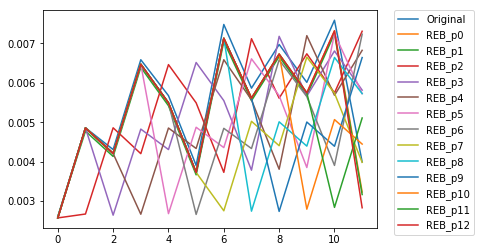

In [35]:
h=Rends
Idx = h.columns
for i in range(len(Idx)):
    plt.plot(h[h.columns[i]], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Desviaciones estandar o variaciones

In [36]:
Stds

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.021416,0.021739,0.021416,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739,0.021739
1,1.718556,1.842719,1.705870,0.021710,1.842719,1.842719,1.842719,1.842719,1.842719,1.842719,1.842719,1.842719,1.842719,1.842719
2,0.021745,0.021537,0.021242,1.718556,0.021582,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537,0.021537
3,0.021498,0.021187,0.020903,0.021549,1.727873,0.021681,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187,0.021187
4,0.024357,0.023811,0.023508,0.021200,0.021745,1.634053,0.021766,0.023811,0.023811,0.023811,0.023811,0.023811,0.023811,0.023811
5,0.023324,0.022866,0.022590,0.023820,0.021431,0.021853,1.802567,0.021663,0.022866,0.022866,0.022866,0.022866,0.022866,0.022866
6,0.024916,0.023703,0.023420,0.022876,0.024065,0.021498,0.021940,1.696678,0.022043,0.023703,0.023703,0.023703,0.023703,0.023703
7,0.022183,0.021032,0.020769,0.023712,0.023105,0.024161,0.021585,0.021830,1.717328,0.022002,0.021032,0.021032,0.021032,0.021032
8,0.024273,0.023371,0.023088,0.021049,0.023962,0.023190,0.024357,0.021479,0.022194,1.758705,0.021992,0.023371,0.023371,0.023371
9,0.022860,0.021616,0.021357,0.023367,0.021298,0.024042,0.023378,0.024254,0.021822,0.022153,1.665246,0.022219,0.021616,0.021616


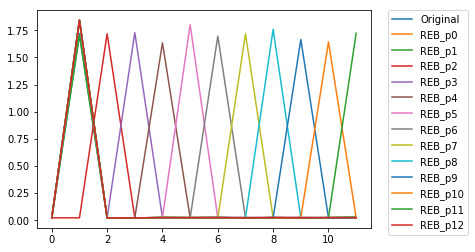

In [37]:
h=Stds
Idx = h.columns
for i in range(len(Idx)):
    plt.plot(h[h.columns[i]], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Sharpe = Que tanto se compensa un inversor al asumir un riesgo. (Punto máximo de rendimiento).

In [38]:
Sharpe

,Original,REB_p0,REB_p1,REB_p2,REB_p3,REB_p4,REB_p5,REB_p6,REB_p7,REB_p8,REB_p9,REB_p10,REB_p11,REB_p12
0,0.092910,0.090040,0.092910,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040,0.090040
1,0.002497,0.002327,0.002467,0.094709,0.002327,0.002327,0.002327,0.002327,0.002327,0.002327,0.002327,0.002327,0.002327,0.002327
2,0.165105,0.162034,0.160790,0.002497,0.093926,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034,0.162034
3,0.273676,0.272256,0.272306,0.161770,0.002465,0.094600,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256,0.272256
4,0.198717,0.195517,0.195008,0.271700,0.165105,0.002623,0.094903,0.195517,0.195517,0.195517,0.195517,0.195517,0.195517,0.195517
5,0.133472,0.128366,0.127245,0.195549,0.271284,0.165536,0.002388,0.094439,0.128366,0.128366,0.128366,0.128366,0.128366,0.128366
6,0.268004,0.266952,0.266664,0.128406,0.195891,0.273676,0.165913,0.002522,0.096988,0.266952,0.266952,0.266952,0.266952,0.266952
7,0.227149,0.227493,0.227280,0.266392,0.129511,0.195970,0.273627,0.165640,0.002595,0.096736,0.227493,0.227493,0.227493,0.227493
8,0.248017,0.247152,0.247550,0.227255,0.266138,0.130070,0.198717,0.273711,0.166161,0.002527,0.096504,0.247152,0.247152,0.247152
9,0.252721,0.254964,0.254922,0.247519,0.227198,0.265974,0.130882,0.198558,0.272691,0.165990,0.002665,0.098063,0.254964,0.254964


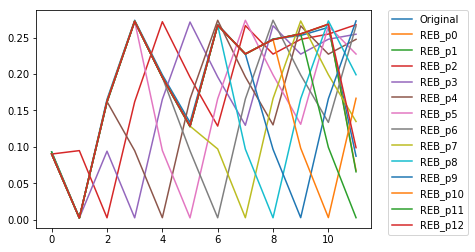

In [39]:
h=Sharpe
Idx = h.columns
for i in range(len(Idx)):
    plt.plot(h[h.columns[i]], label = Idx[i]) 
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

###  Comparacion de Resultados anual - MEDIDAS DE DESEMPEÑO

In [51]:
anual= pd.DataFrame(columns=['Rendimiento','Volatilidad','Sharpe'])
anual['Rendimiento']=Rends.mean()
anual['Volatilidad']=Stds.mean()
anual['Sharpe']=Sharpe.mean()
anual

,Rendimiento,Volatilidad,Sharpe
Original,0.005486,0.165072,0.184437
REB_p0,0.005256,0.174655,0.181893
REB_p1,0.005194,0.162997,0.181721
REB_p2,0.005208,0.163672,0.184007
REB_p3,0.005042,0.316257,0.162170
REB_p4,0.004929,0.308465,0.154793
REB_p5,0.004926,0.322381,0.157181
REB_p6,0.004900,0.313701,0.154693
REB_p7,0.004656,0.315464,0.143555
REB_p8,0.004913,0.318900,0.154535


Entre mayor sea el Sharpe ratio, mejor es la rentabilidad del fondo en relación a la cantidad de riesgo que se ha tomado en la inversión.

### PROPUESTA DE REBALANCEO

### CONCLUSIONES
.....

### BIBLIOGRAFÍA
https://www.portafolio.co/economia/finanzas/son-etf-293754

https://economipedia.com/definiciones/etf-fondos-cotizados.html

https://www.ishares.com/us/products/239508/#/

https://www.quandl.com/tools/python

